# 2024/08/09, 2024/08/13

total elapsed time(cpu): 4.8549029 min


Text(0, 0.5, 'running mean')

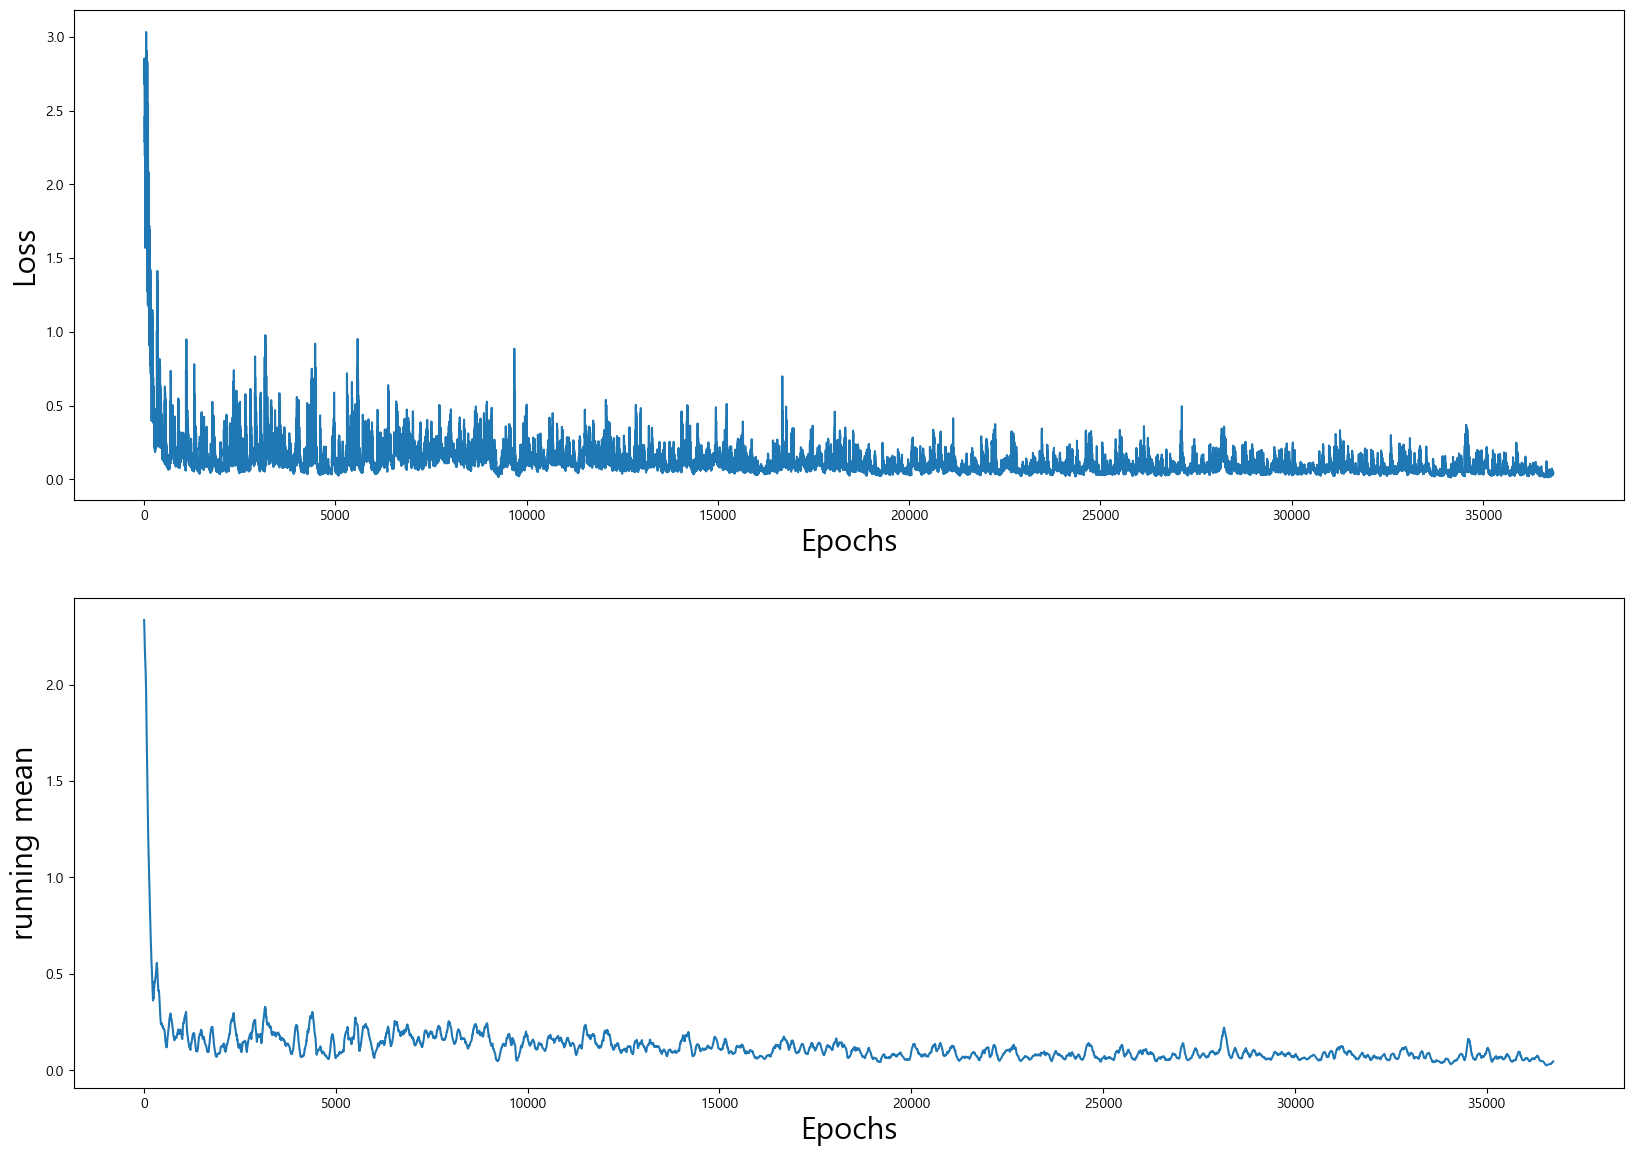

In [23]:
''' 경험 재현(experience replay) '''

from lib.Gridworld import Gridworld
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
from collections import deque
import time

''' 이동 평균 계산 함수 '''
def running_mean(x, N=50):
    ''' M개의 데이터에서 N개씩 이동 평균을 계산한다고 했을 때,
        반환되는 이동 평균값의 개수 = M - N + 1 '''
    c = x.shape[0] - N # 전체 데이터 개수 - 이동 평균을 계산할 데이터의 개수
    y = np.zeros(c + 1) # 이동 평균을 저장하기 위한 벡터
    conv = np.ones(N) # N개의 데이터에 대한 이동 평균 계산 과정에서의 합연산 구현을 위한 벡터
    for i in range(c + 1): # 그냥 c만 사용하면 x의 마지막 데이터는 이동 평균 계산에서 제외돼버린다
        y[i] = (x[i:i+N] @ conv) / N # @는 원소별 곱(element-wise multiplication)을 의미한다
    return y

l1 = 64 # 입력층 노드 개수
l2 = 150 # 첫번째 은닉층 노드 개수
l3 = 100 # 두번째 은닉층 노드 개수
l4 = 4 # 출력층 노드 개수

model = nn.Sequential(
    nn.Linear(l1, l2),
    nn.ReLU(),
    nn.Linear(l2, l3),
    nn.ReLU(),
    nn.Linear(l3, l4)
)

action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

loss_fn = nn.MSELoss()
lr = 1e-3 # 0.003
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

gamma = 0.9 # 할인율
epsilon = 0.3 # 엡실론 탐욕 정책을 위한 초매개변수

epochs = 5000
losses = []
mem_size = 1000 # replay memory 크기
batch_size = 500 # 미니 배치 크기
replay = deque(maxlen=mem_size) # replay memory 생성; deque는 파이썬 내장 모듈인 collections로 부터 나온 것이다
max_moves = 50 # 게임당(한 에피소드당) 최대 이동 수
# h = 0 # 선언되어있기는 한데 사용처가 없어서 왜 있는지 모르겠는 변수

start = time.time()
for i in range(epochs):
    game = Gridworld(size=4, mode="random")
    state1_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 100.0 # ReLU() 함수의 0이하의 값은 모두 0으로 사상하는 특성으로 인한 "dead neuron" 현상을 막기위해 잡음을 추가한다
    state1 = torch.from_numpy(state1_).float()
    status = 1 # 게임 종료 여부
    mov = 0 # 취한 행동 횟수
    while (status == 1):
        mov += 1
        qval = model(state1) # 행동 가치 계산
        qval_ = qval.data.numpy()

        ''' 엡실론 탐욕 전략 '''
        if(random.random() < epsilon):
            action_ = np.random.randint(0, 4) # 탐험(exploration)
        else:
            action_ = np.argmax(qval_) # 활용(exploitation)
        action = action_set[action_]
        game.makeMove(action)

        state2_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 100.0 # 다음 상태 계산
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward() # 보상 계산

        ''' 첫번째 done 코드가 두번째 done 코드보다 결과가 더 좋은 것을 볼 수 있는데 이에 대하여 한 가지 가설을 제안한다
            가설 : 에이전트가 긍정적인 경험 때와 동일한 크기의 부호만 반대인 부정적인 경험(여기서는 함정에 도달하여 -10점을 받는 경우)을 학습할 때,
            부정적인 경험을 어느정도 감소시킨 후 긍정적인 경험과 결합도록하면(모델 학습에 반영하면) 모델의 긍정적인 경험이 일부 잔존하도록 할 수 있다 '''
        ''' 다음 상태로 게임에서 패배하였을 때 게임이 종료되었으므로 목표 Q 가치(Q 러닝의 레이블 항) 계산시 maxQ는 무시하고 reward만 고려하는 것이 맞는데, 
            maxQ를 제외하지않고 계산하여 목표 Q 가치가 -10에서 +10으로 조금 이동하도록 만든다(즉, 게임 패배의 결과가 모델 학습에 미치는 영향을 조금 약화시킨다) '''
        done = True if reward > 0 else False # 게임의 종료 여부
        # done = True if reward != -1 else False

        ''' 경험 재현(experience replay) '''
        exp = (state1, action_, reward, state2, done) # 경험 생성
        replay.append(exp)
        state1 = state2 # 현재 상태 갱신

        if len(replay) > batch_size:
            minibatch = random.sample(replay, batch_size)
            # state1과 state2는 2차원 텐서들로, 이들을 하나의 2차원 텐서 형태의 데이터셋으로 만들어주기 위해 torch.cat()을 사용했다
            state1_batch = torch.cat([s1 for (s1, a, r, s2, d) in minibatch]) # batch_size X 4 형태의 텐서
            action_batch = torch.tensor([a for (s1, a, r, s2, d) in minibatch]) # 크키가 batch_size인 1차원 텐서
            reward_batch = torch.tensor([r for (s1, a, r, s2, d) in minibatch]) # 크키가 batch_size인 1차원 텐서
            state2_batch = torch.cat([s2 for (s1, a, r, s2, d) in minibatch]) # batch_size X 4 형태의 텐서
            done_batch = torch.tensor([d for (s1, a, r, s2 ,d) in minibatch], dtype=torch.int64) # 크키가 batch_size인 1차원 텐서

            Q1 = model(state1_batch) # Q러닝 공식의 예측항 계산
            with torch.no_grad():
                Q2 = model(state2_batch) # batch_size X 4 형태의 텐서가 반환된다
            Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2, dim=1)[0]) # Q러닝 공식의 레이블 항(목표 행동 가치) 계산
            X = Q1.gather(dim=1, index=action_batch.long().unsqueeze(dim=1)).squeeze() # batch_size X 1 형태의 텐서를 크기가 batch_size인 1차원 텐서로 변환한다
            loss = loss_fn(X, Y.detach()) # 위에서 torch.no_grad()를 사용했으므로 굳이 detach()를 해줄 필요는 없다
            print(f"current epoch: {i}, loss: {loss.item()}")
            clear_output(wait=True)

            ''' 역전파 '''
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if reward != -1 or mov > max_moves: # 게임에서 이기거나 진경우, 그리고 최대 수행 횟수를 넘어선 경우
            status = 0 # 게임 종료
            mov = 0 # 취한 행동 횟수 초기화
end = time.time()
print(f"total elapsed time(cpu): {(end - start) / 60.0:.7f} min")
losses = np.array(losses) # 크키가 n인 1차원 ndarray

''' 손실 그래프 출력 '''
plt.figure(figsize=(20, 14))
plt.subplot(2, 1, 1)
plt.plot(losses)
plt.xlabel("Epochs", fontsize=22)
plt.ylabel("Loss", fontsize=22)

plt.subplot(2, 1, 2)
plt.plot(running_mean(losses, 100))
plt.xlabel("Epochs", fontsize=22)
plt.ylabel("running mean", fontsize=22)

device type: cuda
current device: 0
number of device: 1
current epoch: 3, loss: 0.9801032543182373
current epoch: 3, loss: 0.9814344644546509
current epoch: 3, loss: 0.9635982513427734
current epoch: 3, loss: 0.9350521564483643
current epoch: 4, loss: 0.9065589904785156
current epoch: 4, loss: 0.8819643259048462
current epoch: 4, loss: 0.8552647233009338
current epoch: 4, loss: 0.8311696648597717
current epoch: 4, loss: 0.8081556558609009
current epoch: 4, loss: 0.783381462097168
current epoch: 4, loss: 0.7553992867469788
current epoch: 4, loss: 0.7372774481773376
current epoch: 4, loss: 0.7125042676925659
current epoch: 4, loss: 0.6879668831825256
current epoch: 4, loss: 0.6467591524124146
current epoch: 4, loss: 0.620732307434082
current epoch: 4, loss: 0.5869502425193787
current epoch: 4, loss: 0.5671592354774475
current epoch: 4, loss: 0.9842532277107239
current epoch: 5, loss: 0.9551586508750916
current epoch: 5, loss: 0.9177120923995972
current epoch: 5, loss: 0.8883700370788574


Text(0, 0.5, 'running mean')

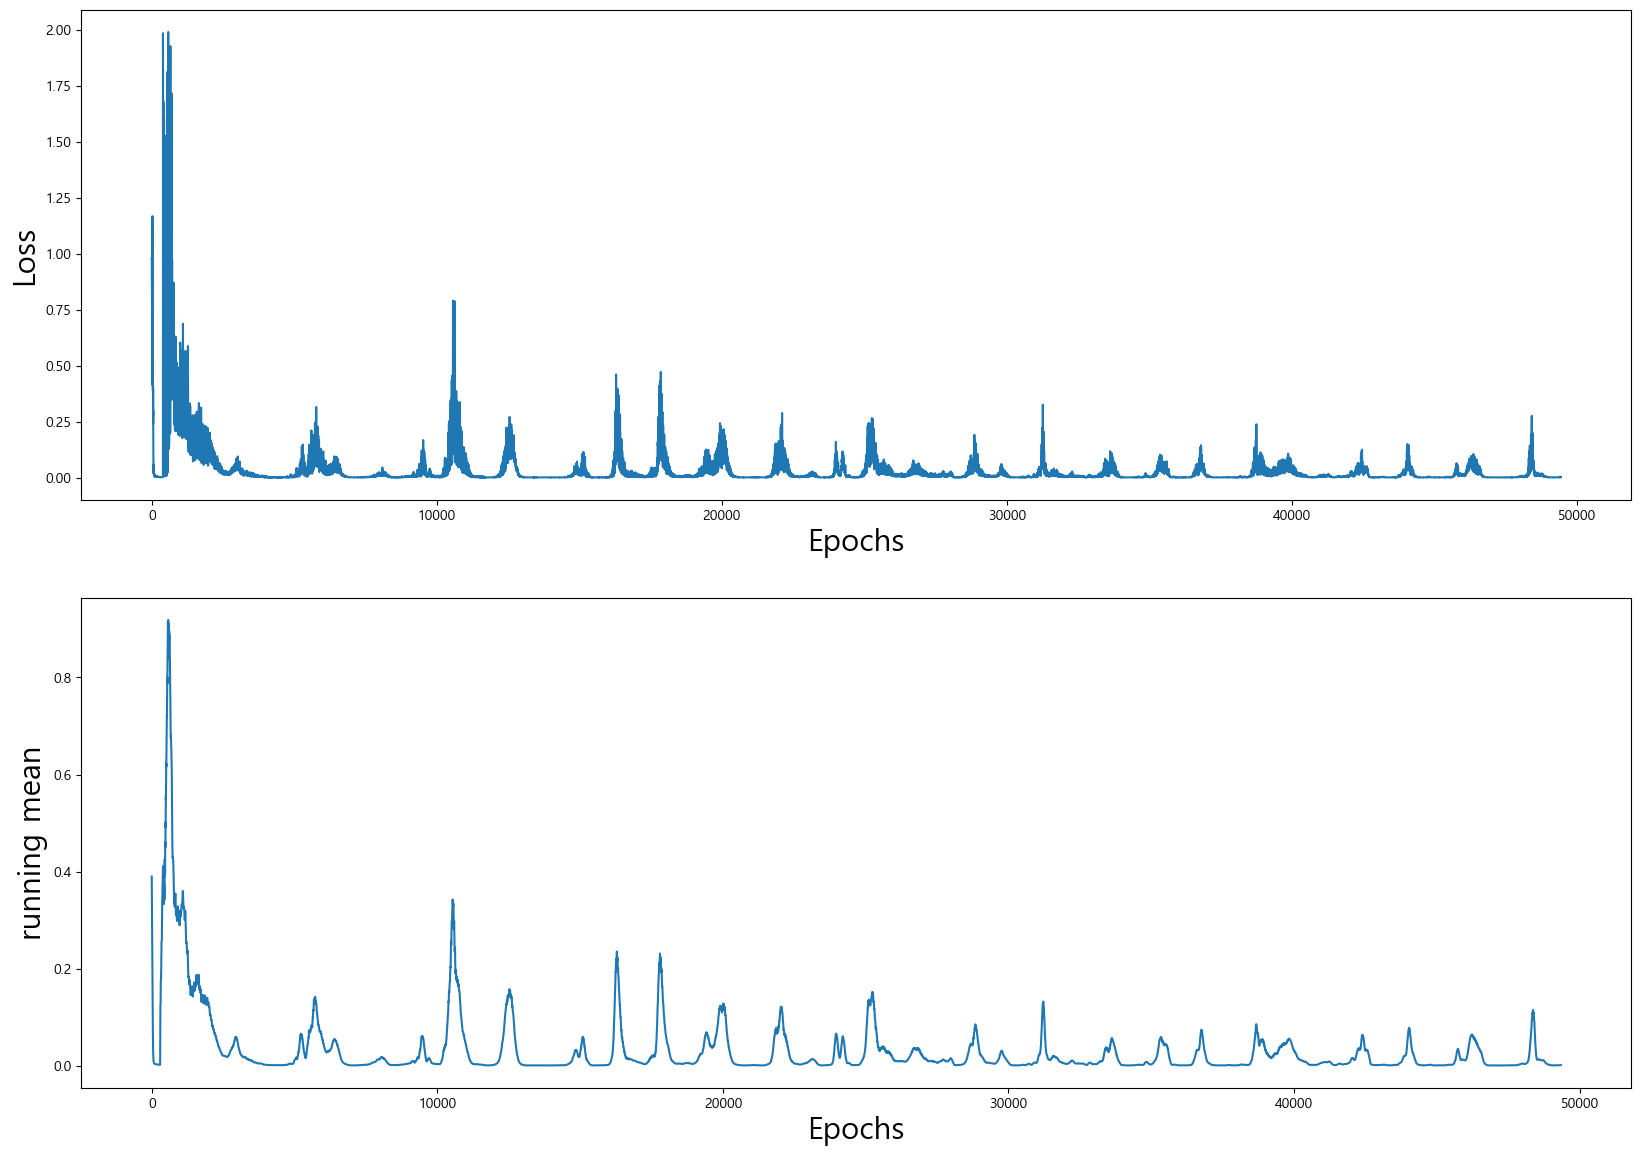

In [11]:
''' 경험 재현(experience replay) ver.GPU(I/O에서 지연이 발생해 CPU에서보다 실행 시간이 더 오래 걸린다) '''

from lib.Gridworld import Gridworld
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
from collections import deque
import time

''' 이동 평균 계산 함수 '''
def running_mean(x, N=50):
    ''' M개의 데이터에서 N개씩 이동 평균을 계산한다고 했을 때,
        반환되는 이동 평균값의 개수 = M - N + 1 '''
    c = x.shape[0] - N # 전체 데이터 개수 - 이동 평균을 계산할 데이터의 개수
    y = np.zeros(c + 1) # 이동 평균을 저장하기 위한 벡터
    conv = np.ones(N) # N개의 데이터에 대한 이동 평균 계산 과정에서의 합연산 구현을 위한 벡터
    for i in range(c + 1): # 그냥 c만 사용하면 x의 마지막 데이터는 이동 평균 계산에서 제외돼버린다
        y[i] = (x[i:i+N] @ conv) / N # @는 원소별 곱(element-wise multiplication)을 의미한다
    return y

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device type: {device}")
print(f"current device: {torch.cuda.current_device()}")
print(f"number of available device: {torch.cuda.device_count()}")

l1 = 64 # 입력층 노드 개수
l2 = 150 # 첫번째 은닉층 노드 개수
l3 = 100 # 두번째 은닉층 노드 개수
l4 = 4 # 출력층 노드 개수

model = nn.Sequential(
    nn.Linear(l1, l2),
    nn.ReLU(),
    nn.Linear(l2, l3),
    nn.ReLU(),
    nn.Linear(l3, l4)
).to(device)

action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

loss_fn = nn.MSELoss()
lr = 1e-3 # 0.003
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

gamma = 0.9 # 할인율
epsilon = 0.3 # 엡실론 탐욕 정책을 위한 초매개변수

epochs = 5000
losses = []
mem_size = 1000 # replay memory 크기
batch_size = 200 # 미니 배치 크기
replay = deque(maxlen=mem_size) # replay memory 생성; deque는 파이썬 내장 모듈인 collections로 부터 나온 것이다
max_moves = 50 # 게임당(한 에피소드당) 최대 이동 수
# h = 0 # 선언되어있기는 한데 사용처가 없어서 왜 있는지 모르겠는 변수

start = time.time()
for i in range(epochs):
    game = Gridworld(size=4, mode="static") # 환경 생성

    ''' 현재 상태 계산 '''
    state1_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 100.0 # ReLU() 함수의 0이하의 값은 모두 0으로 사상하는 특성으로 인한 "dead neuron" 현상을 막기위해 잡음을 추가한다
    state1 = torch.from_numpy(state1_).float().to(device) # 1 X 64 형태의 2차원 텐서가 반환된다
    
    status = 1 # 게임 종료 여부
    mov = 0 # 취한 행동 횟수

    ''' 게임(에피소드) 한 번 실행 '''
    while (status == 1):
        mov += 1
        qval = model(state1) # 행동 가치 계산; qval은 1 X 4 형태의 텐서이다

        ''' 엡실론 탐욕 전략 '''
        if(random.random() < epsilon):
            action_ = np.random.randint(0, 4) # 탐험(exploration)
        else:
            action_ = torch.argmax(qval, dim=1).item() # 활용(exploitation)
        action = action_set[action_]
        game.makeMove(action)

        state2_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 100.0 # 다음 상태 계산
        state2 = torch.from_numpy(state2_).float().to(device)
        reward = game.reward() # 보상 계산
        done = True if reward > 0 else False # 게임의 종료 여부
        # done = True if reward != -1 else False # 게임의 종료 여부

        ''' 경험 재현(experience replay) '''
        exp = (state1, action_, reward, state2, done) # 경험 생성
        replay.append(exp)
        state1 = state2 # 현재 상태 갱신

        if len(replay) > batch_size:
            minibatch = random.sample(replay, batch_size)
            # state1과 state2는 2차원 텐서들로, 이들을 하나의 2차원 텐서 형태의 데이터셋으로 만들어주기 위해 torch.cat()을 사용했다
            state1_batch = torch.cat([s1 for (s1, a, r, s2, d) in minibatch], dim=0) # batch_size X 4 형태의 텐서
            action_batch = torch.tensor([a for (s1, a, r, s2, d) in minibatch], dtype=torch.float, device=device) # 크키가 batch_size인 1차원 텐서
            reward_batch = torch.tensor([r for (s1, a, r, s2, d) in minibatch], dtype=torch.float, device=device) # 크키가 batch_size인 1차원 텐서
            state2_batch = torch.cat([s2 for (s1, a, r, s2, d) in minibatch], dim=0) # batch_size X 4 형태의 텐서
            done_batch = torch.tensor([d for (s1, a, r, s2 ,d) in minibatch], dtype=torch.float, device=device) # 크키가 batch_size인 1차원 텐서

            ''' Q러닝 공식의 예측항 계산 '''
            Q1 = model(state1_batch)
            X = Q1.gather(dim=1, index=action_batch.long().unsqueeze(dim=1)).squeeze() # batch_size X 1 형태의 텐서를 크기가 batch_size인 1차원 텐서로 변환한다

            ''' Q러닝 공식의 레이블항(목표 ) 계산 '''
            with torch.no_grad():
                Q2 = model(state2_batch) # batch_size X 4 형태의 텐서가 반환된다
            Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2, dim=1)[0]) # Q러닝 공식의 레이블 항(목표 행동 가치) 계산
            
            loss = loss_fn(X, Y.detach()) # 위에서 torch.no_grad()를 사용했으므로 굳이 detach()를 해줄 필요는 없다
            print(f"current epoch: {i}, loss: {loss.item()}")
            # clear_output(wait=True)

            ''' 역전파 '''
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if reward != -1 or mov > max_moves: # 게임에서 이기거나 진경우, 그리고 최대 수행 횟수를 넘어선 경우
            status = 0 # 게임 종료
            mov = 0 # 취한 행동 횟수 초기화
end = time.time()
print(f"total elapsed time(cpu): {(end - start) / 60.0:.7f} min")
losses = np.array(losses) # 크키가 n인 1차원 ndarray

''' 손실 그래프 출력 '''
plt.figure(figsize=(20, 14))
plt.subplot(2, 1, 1)
plt.plot(losses)
plt.xlabel("Epochs", fontsize=22)
plt.ylabel("Loss", fontsize=22)

plt.subplot(2, 1, 2)
plt.plot(running_mean(losses, 100))
plt.xlabel("Epochs", fontsize=22)
plt.ylabel("running mean", fontsize=22)

In [3]:
def test_model(model, mode="static", display=True):
    i = 0 # 취한 행동 개수

    ''' 환경 생성 '''
    test_game = Gridworld(mode=mode) # 환경 생성(기본이 4 X 4 형식인 것 같다)

    ''' 초기 상태 계산 '''
    state_ = test_game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 100.0
    state = torch.from_numpy(state_).float()

    ''' 게임(에피소드) 실행 '''
    status = 1 # 게임 종료 여부
    while(status == 1):
        qval = model(state) # 행동 가치 벡터 계산
        qval_ = qval.data.numpy()

        ''' 행동 선택 및 실행 '''
        action_ = np.argmax(qval_)
        action = action_set[action_]
        if display: # 취한 행동 표시
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.makeMove(action)

        ''' 상태 갱신 '''
        state_ = test_game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 100.0
        state = torch.from_numpy(state_).float()
        if display: # 게임 상태 표시
            print(test_game.display())

        ''' 보상 계산 '''
        reward = test_game.reward()        
        if reward != -1: # 게임이 종료 되었는지 여부를 확인
            if reward > 0: # 도착점에 도착해서 +10점을 받은 경우
                status = 2 # 게임에서 승리했음을 의미한다
                if display:
                    print("Game won!, Reward: %s" % (reward))
            else: # 함정에 도착해서 -10점을 받은 경우
                status = 0 # 게임에서 패배했음을 의미한다
                if display:
                    print("Game Lost!, Reward: %s" % (reward))

        i += 1 # 취한 행동의 횟수 갱신
        if i > 15: # 너무 많은 행동을 취한 경우
            if display:
                print("Game Lost!, too many moves.")
            break
        
    win = True if status == 2 else False
    return win

start = time.time()
test_model(model, "random")
end = time.time()
print(f"running time : {(end - start) / 60:.7f} min")

Move #: 0; Taking action: r
[[' ' ' ' ' ' ' ']
 [' ' ' ' 'W' ' ']
 [' ' 'P' '+' ' ']
 ['-' ' ' ' ' ' ']]
Move #: 1; Taking action: r
[[' ' ' ' ' ' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' '+' ' ']
 ['-' ' ' ' ' ' ']]
Game won!, Reward: 10
running time : 0.0000471 min


In [22]:
''' agent test '''
max_games = 1000 # 1000번의 게임(에피소드)을 플레이한다
wins = 0
for i in range(max_games):
    win = test_model(model, mode="random", display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games) # 승률 계산
print("Games played: {0}, # of wins: {1}".format(max_games, wins))
print("Win percentage: {}%".format(100.0 * win_perc))

Games played: 1000, # of wins: 876
Win percentage: 87.6%


# 2024/08/14

total elapsed time(cpu): 18.8302724 min


Text(0, 0.5, 'running mean')

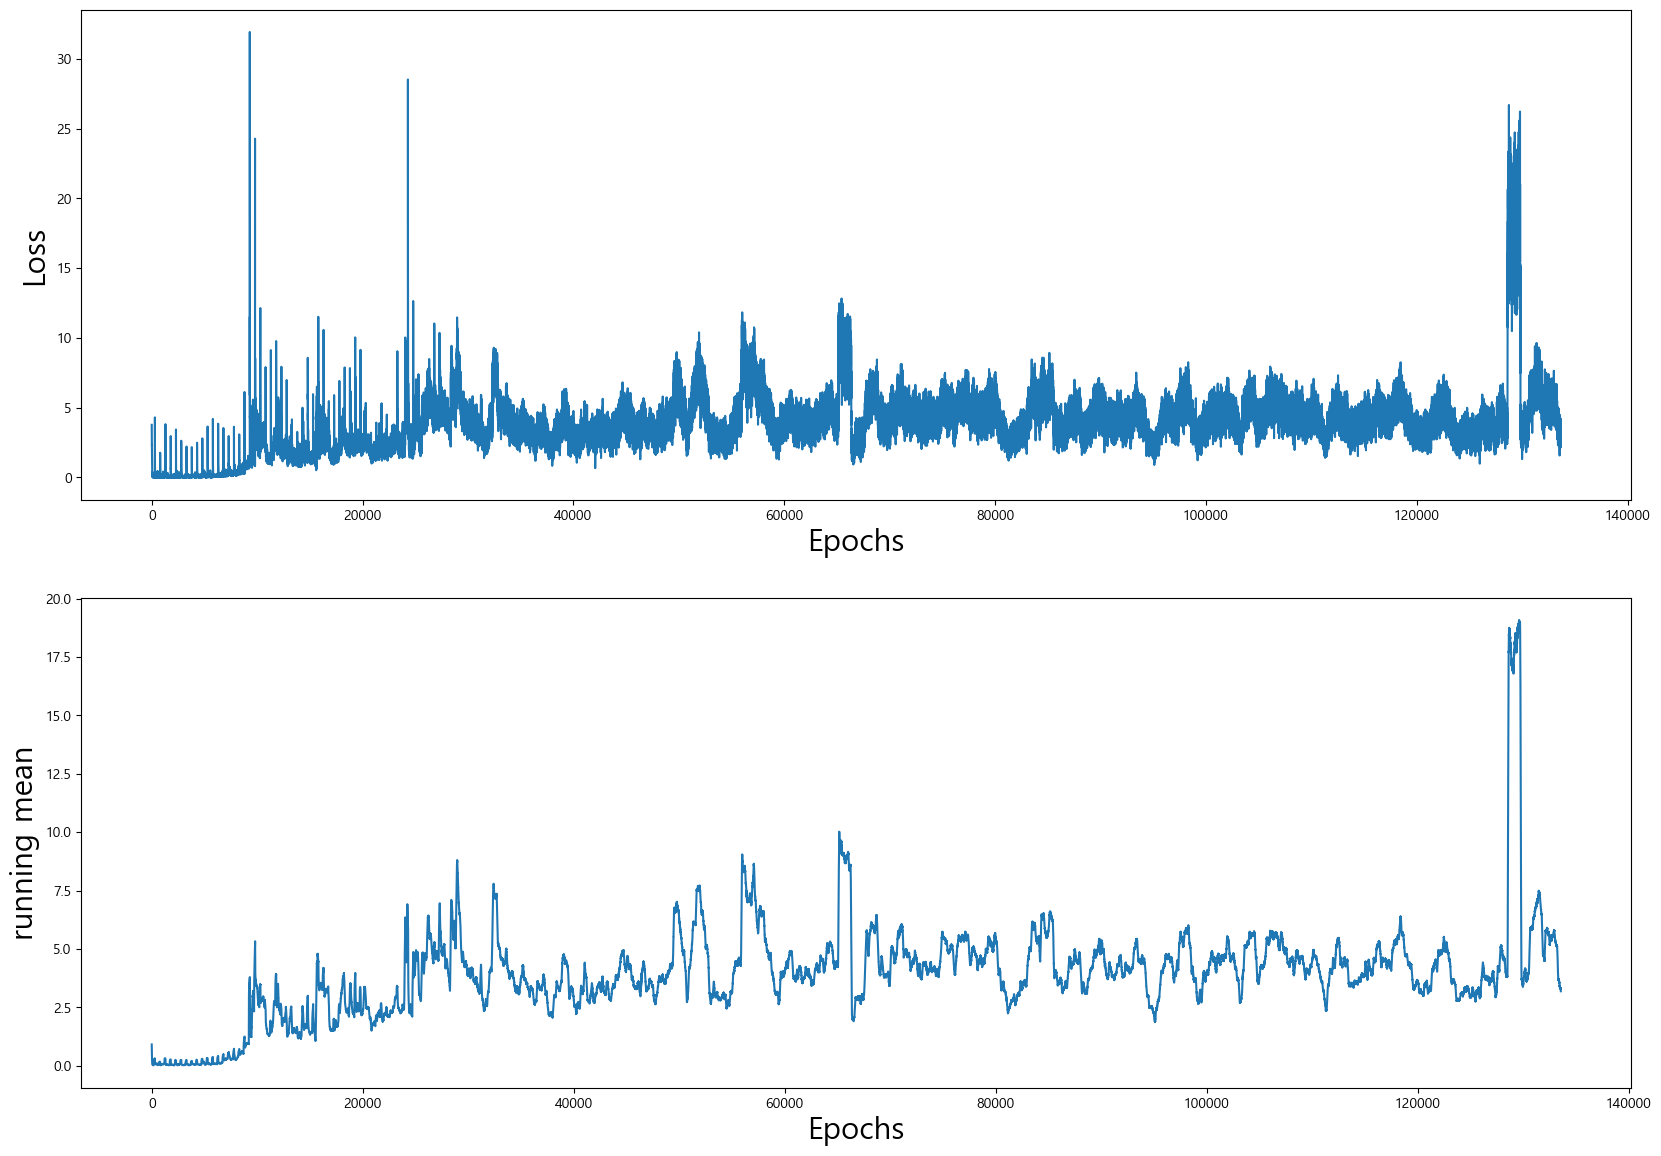

In [13]:
''' 목표망(target network) '''

import copy
from collections import deque
from lib.Gridworld import Gridworld
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from IPython.display import clear_output

''' 이동 평균 계산 함수 '''
def running_mean(x, N=50):
    ''' M개의 데이터에서 N개씩 이동 평균을 계산한다고 했을 때,
        반환되는 이동 평균값의 개수 = M - N + 1 '''
    c = x.shape[0] - N # 전체 데이터 개수 - 이동 평균을 계산할 데이터의 개수
    y = np.zeros(c + 1) # 이동 평균을 저장하기 위한 벡터
    conv = np.ones(N) # N개의 데이터에 대한 이동 평균 계산 과정에서의 합연산 구현을 위한 벡터
    for i in range(c + 1): # 그냥 c만 사용하면 x의 마지막 데이터는 이동 평균 계산에서 제외돼버린다
        y[i] = (x[i:i+N] @ conv) / N # @는 원소별 곱(element-wise multiplication)을 의미한다
    return y

l1 = 64 # 입력층 노드 개수
l2 = 150 # 첫번째 은닉층 노드 개수
l3 = 100 # 두번째 은닉층 노드 개수
l4 = 4 # 출력층 노드 개수

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)

# state_dict는 파이썬 딕셔너리 객체로 모델의 각 계층을 그것의 매개변수 텐서로 대응시킨다
model2 = copy.deepcopy(model) # 목표망(target network) 생성
model2.load_state_dict(model.state_dict()) # 주 Q 신경망의 매개변수를 목표망에 불러온다

action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

loss_fn = nn.MSELoss()
lr = 1e-2 # 0.03
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=600, gamma=0.1)

gamma = 0.9 # 할인율
epsilon = 0.3

epochs = 5000
losses = []
mem_size = 1200 # replay memory의 크기
batch_size = 700
replay = deque(maxlen=mem_size) # replay memory 생성
max_moves = 50 # 에이전트가 한 게임(에피소드)에서 취할 수 있는 행동의 횟수
sync_freq = 500 # 목표망의 매개변수를 갱신할 time step주기를 나타낸다
j = 0 # 현재 몇 번째 time_step인지 센다

start = time.time()
for i in range(epochs):
    game = Gridworld(size=4, mode='random') # 환경 생성

    ''' 현재 상태 계산 '''
    state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64) / 100.0
    state1 = torch.from_numpy(state1_).float()
    
    status = 1 # 게임 진행 여부
    mov = 0 # 에이전트의 행동 횟수

    ''' 게임(에피소드) 한 번 실행 '''
    while(status == 1): 
        j += 1 # 현재 몇 번째 time step인지 센다
        mov += 1 # 현재 time step에서 취할 행동을 미리 횟수로 센다
        qval = model(state1)
        qval_ = qval.data.numpy()

        ''' 엡실론 탐욕전략 '''
        if (random.random() < epsilon):
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_]
        game.makeMove(action)

        ''' 다음 상태 계산 '''
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64) / 100.0
        state2 = torch.from_numpy(state2_).float()
        
        reward = game.reward()
        done = True if reward > 0 else False # 게임 종료 여부

        exp = (state1, action_, reward, state2, done) # 경험 생성
        replay.append(exp) # replay memory에 경험 추가
        state1 = state2 # 현재 상태 갱신
        ''' 경험 재현(experience replay) '''
        if len(replay) > batch_size:
            minibatch = random.sample(replay, batch_size)
            # state1과 state2는 2차원 텐서들로, 이들을 하나의 2차원 텐서 형태의 데이터셋으로 만들어주기 위해 torch.cat()을 사용했다
            state1_batch = torch.cat([s1 for (s1, a, r, s2, d) in minibatch]) # batch_size X 4 형태의 텐서
            action_batch = torch.tensor([a for (s1, a, r, s2, d) in minibatch]) # 크키가 batch_size인 1차원 텐서
            reward_batch = torch.tensor([r for (s1, a, r, s2, d) in minibatch]) # 크키가 batch_size인 1차원 텐서
            state2_batch = torch.cat([s2 for (s1, a, r, s2, d) in minibatch]) # batch_size X 4 형태의 텐서
            done_batch = torch.tensor([d for (s1, a, r, s2 ,d) in minibatch], dtype=torch.int64) # 크키가 batch_size인 1차원 텐서

            ''' Q 러닝 공식의 예측항 계산 '''
            Q1 = model(state1_batch) # batch_size X 4 형태의 2차원 텐서가 반환된다
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze() # 크기가 batch_size인 1차원 텐서가 반환된다
                                                                                      # long = torch.int64            
            ''' Q 러닝 공식의 레이블항(목표 Q 가치) 계산 '''
            with torch.no_grad():
                Q2 = model2(state2_batch) # batch_size X 4 형태의 2차원 텐서가 반환된다
            Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2, dim=1)[0]) # 크기가 batch_size인 1차원 텐서가 반환된다
            
            loss = loss_fn(X, Y.detach()) # 위에서 torch.no_grad()를 사용했으므로 굳이 detach()를 해줄 필요는 없다
            print(f"current epoch: {i}, loss: {loss.item()}")
            clear_output(wait=True)

            ''' 역전파 '''
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())

            if j % sync_freq == 0: # sync_freq 주기의 time_step마다 목표망의 매개변수들을 주 Q 신경망의 것으로 갱신한다
                model2.load_state_dict(model.state_dict())
        
        if reward != -1 or mov > max_moves: # 게임에서 승리/패배하거나 제한된 행동 횟수를 넘어선 경우 게임이 종료된다
            status = 0
            mov = 0 # 다음 게임(에피소드)을 위해 초기화
    scheduler.step() # 학습률 갱신

end = time.time()
print(f"total elapsed time(cpu): {(end - start) / 60.0:.7f} min")
losses = np.array(losses) # 크키가 n인 1차원 ndarray

''' 손실 그래프 출력 '''
plt.figure(figsize=(20, 14))
plt.subplot(2, 1, 1)
plt.plot(losses)
plt.xlabel("Epochs", fontsize=22)
plt.ylabel("Loss", fontsize=22)

plt.subplot(2, 1, 2)
plt.plot(running_mean(losses, 100))
plt.xlabel("Epochs", fontsize=22)
plt.ylabel("running mean", fontsize=22)

total elapsed time(cpu): 24.0803658 min


Text(0, 0.5, 'running mean')

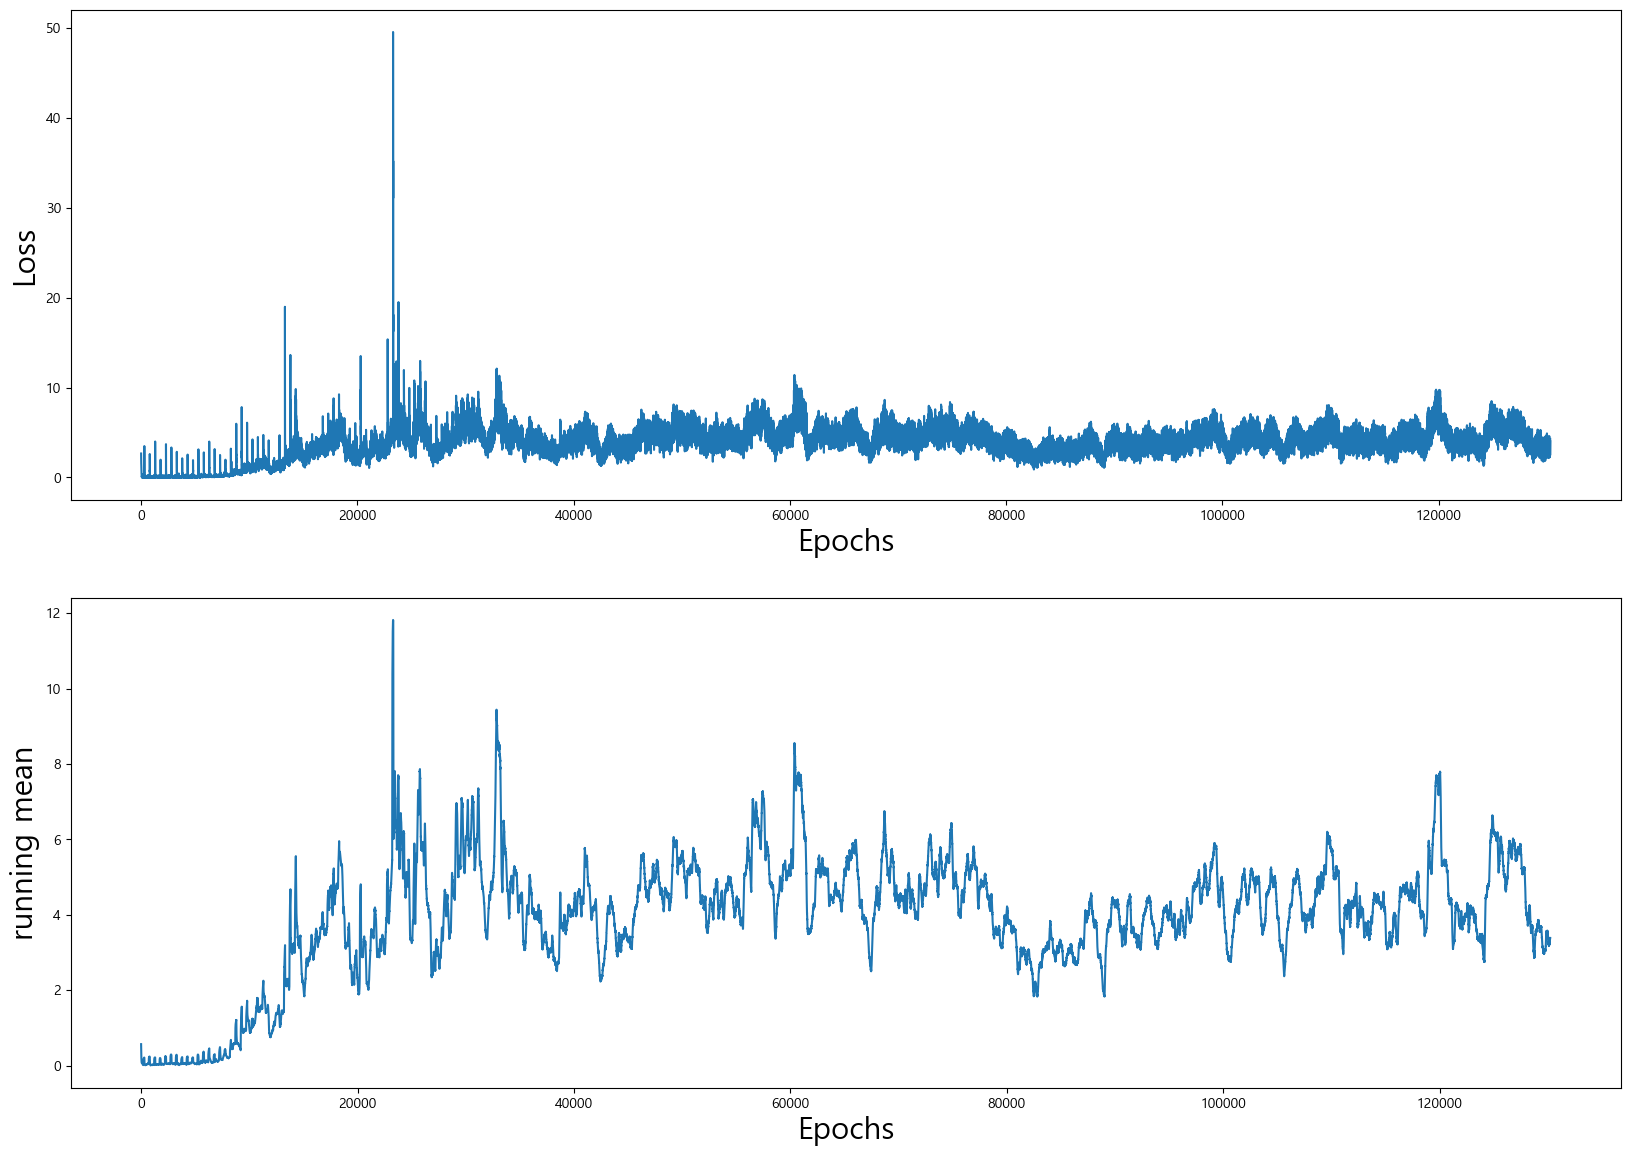

In [14]:
''' 목표망(target network) '''

import copy
from collections import deque
from lib.Gridworld import Gridworld
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from IPython.display import clear_output

''' 이동 평균 계산 함수 '''
def running_mean(x, N=50):
    ''' M개의 데이터에서 N개씩 이동 평균을 계산한다고 했을 때,
        반환되는 이동 평균값의 개수 = M - N + 1 '''
    c = x.shape[0] - N # 전체 데이터 개수 - 이동 평균을 계산할 데이터의 개수
    y = np.zeros(c + 1) # 이동 평균을 저장하기 위한 벡터
    conv = np.ones(N) # N개의 데이터에 대한 이동 평균 계산 과정에서의 합연산 구현을 위한 벡터
    for i in range(c + 1): # 그냥 c만 사용하면 x의 마지막 데이터는 이동 평균 계산에서 제외돼버린다
        y[i] = (x[i:i+N] @ conv) / N # @는 원소별 곱(element-wise multiplication)을 의미한다
    return y

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device type: {}".format(device))
print("current device: {}".format(torch.cuda.current_device()))
print("number of available device: {}".format(torch.cuda.device_count()))

l1 = 64 # 입력층 노드 개수
l2 = 150 # 첫번째 은닉층 노드 개수
l3 = 100 # 두번째 은닉층 노드 개수
l4 = 4 # 출력층 노드 개수

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
).to(device)

https://crackerjacks.tistory.com/14
# state_dict는 파이썬 딕셔너리 객체로 모델의 각 계층을 그것의 매개변수 텐서로 대응시킨다
model2 = copy.deepcopy(model) # 목표망(target network) 생성
model2.load_state_dict(model.state_dict()) # 주 Q 신경망의 매개변수를 목표망에 불러온다

action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

loss_fn = nn.MSELoss()
lr = 1e-2 # 0.03
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=600, gamma=0.1)

gamma = 0.9 # 할인율
epsilon = 0.3

epochs = 5000
losses = []
mem_size = 1200 # replay memory의 크기
batch_size = 700
replay = deque(maxlen=mem_size) # replay memory 생성
max_moves = 50 # 에이전트가 한 게임(에피소드)에서 취할 수 있는 행동의 횟수
sync_freq = 500 # 목표망의 매개변수를 갱신할 time step주기를 나타낸다
j = 0 # 현재 몇 번째 time_step인지 센다

start = time.time()
for i in range(epochs):
    game = Gridworld(size=4, mode='random') # 환경 생성

    ''' 현재 상태 계산 '''
    state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64) / 100.0
    state1 = torch.from_numpy(state1_).float().to(device)
    
    status = 1 # 게임 진행 여부
    mov = 0 # 에이전트의 행동 횟수

    ''' 게임(에피소드) 한 번 실행 '''
    while(status == 1): 
        j += 1 # 현재 몇 번째 time step인지 센다
        mov += 1 # 현재 time step에서 취할 행동을 미리 횟수로 센다
        qval = model(state1) # 행동 가치 계산; qval은 1 X 4 형태의 텐서이다

        ''' 엡실론 탐욕전략 '''
        if (random.random() < epsilon):
            action_ = np.random.randint(0,4)
        else:
            action_ = torch.argmax(qval, dim=1).item()
        action = action_set[action_]
        game.makeMove(action)

        ''' 다음 상태 계산 '''
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64) / 100.0
        state2 = torch.from_numpy(state2_).float().to(device)
        
        reward = game.reward()
        done = True if reward > 0 else False # 게임 종료 여부

        exp = (state1, action_, reward, state2, done) # 경험 생성
        replay.append(exp) # replay memory에 경험 추가
        state1 = state2 # 현재 상태 갱신
        ''' 경험 재현(experience replay) '''
        if len(replay) > batch_size:
            minibatch = random.sample(replay, batch_size)
            # state1과 state2는 2차원 텐서들로, 이들을 하나의 2차원 텐서 형태의 데이터셋으로 만들어주기 위해 torch.cat()을 사용했다
            state1_batch = torch.cat([s1 for (s1, a, r, s2, d) in minibatch], dim=0) # batch_size X 4 형태의 텐서
            action_batch = torch.tensor([a for (s1, a, r, s2, d) in minibatch], dtype=torch.float, device=device) # 크키가 batch_size인 1차원 텐서
            reward_batch = torch.tensor([r for (s1, a, r, s2, d) in minibatch], dtype=torch.float, device=device) # 크키가 batch_size인 1차원 텐서
            state2_batch = torch.cat([s2 for (s1, a, r, s2, d) in minibatch], dim=0) # batch_size X 4 형태의 텐서
            done_batch = torch.tensor([d for (s1, a, r, s2 ,d) in minibatch], dtype=torch.float, device=device) # 크키가 batch_size인 1차원 텐서

            ''' Q 러닝 공식의 예측항 계산 '''
            Q1 = model(state1_batch) # batch_size X 4 형태의 2차원 텐서가 반환된다
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze() # 크기가 batch_size인 1차원 텐서가 반환된다
                                                                                      # long = torch.int64            
            ''' Q 러닝 공식의 레이블항(목표 Q 가치) 계산 '''
            with torch.no_grad():
                Q2 = model2(state2_batch) # batch_size X 4 형태의 2차원 텐서가 반환된다
            Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2, dim=1)[0]) # 크기가 batch_size인 1차원 텐서가 반환된다
            
            loss = loss_fn(X, Y.detach()) # 위에서 torch.no_grad()를 사용했으므로 굳이 detach()를 해줄 필요는 없다
            print(f"current epoch: {i}, loss: {loss.item()}")
            clear_output(wait=True)

            ''' 역전파 '''
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())

            if j % sync_freq == 0: # sync_freq 주기의 time_step마다 목표망의 매개변수들을 주 Q 신경망의 것으로 갱신한다
                model2.load_state_dict(model.state_dict())
        
        if reward != -1 or mov > max_moves: # 게임에서 승리/패배하거나 제한된 행동 횟수를 넘어선 경우 게임이 종료된다
            status = 0
            mov = 0 # 다음 게임(에피소드)을 위해 초기화
    scheduler.step() # 학습률 갱신

end = time.time()
print(f"total elapsed time(cpu): {(end - start) / 60.0:.7f} min")
losses = np.array(losses) # 크키가 n인 1차원 ndarray

''' 손실 그래프 출력 '''
plt.figure(figsize=(20, 14))
plt.subplot(2, 1, 1)
plt.plot(losses)
plt.xlabel("Epochs", fontsize=22)
plt.ylabel("Loss", fontsize=22)

plt.subplot(2, 1, 2)
plt.plot(running_mean(losses, 100))
plt.xlabel("Epochs", fontsize=22)
plt.ylabel("running mean", fontsize=22)

In [ ]:
max_games = 1000 # 게임(에피소드)을 1000번 실행한다
wins = 0
for i in range(max_games):
    win = test_model(model, mode="random", display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games, wins))
print("Win percentage: {}".format(100.0 * win_perc))